# 📘 Starter Code

This notebook is provided to help you get started with loading and exploring the dataset.     
You are **not required** to use this code, but you may find it useful as a reference.     
Because the `ERC20-stablecoins.zip` dataset is distributed as a large ZIP file, you may encounter difficulties downloading or extracting it locally due to storage or memory constraints. The code below demonstrates how to access and read the data directly from the ZIP file, without unzipping it on your computer.

## 📦 Importing Required Library
We begin by importing a few standard Python libraries that will be used to: 
* access ZIP files
* handle in-memory file objects
* load tabular data for analysis

In [1]:
import matplotlib.pyplot as plt
import zipfile
import io
import pandas as pd
import datetime
import numpy as np


## ⚠️ Before you run this notebook
Please make sure that:      
* The file **`ERC20-stablecoins.zip`** is located in the same directory as this notebook     
* You have sufficient memory available to load large CSV files in chunks if needed          

You do **not** need to manually unzip the file.     

## 📂 Explore the Contents of the ZIP File
The dataset is provided as a ZIP archive and contains multiple CSV files, including transaction data, price data, and event-level information.

In [11]:
print("Files in ERC20-stablecoins.zip:")
print("=" * 50)

with zipfile.ZipFile("ERC20-stablecoins.zip", "r") as outer_zip:
    for name in outer_zip.namelist():
        if name.endswith(".csv"):
            print(f"📄 {name}")
        elif name.endswith(".zip"):
            print(f"📦 {name}")
            nested_zip_data = outer_zip.read(name)
            with zipfile.ZipFile(io.BytesIO(nested_zip_data), "r") as inner_zip:
                for inner_name in inner_zip.namelist():
                    if inner_name.endswith(".csv"):
                        print(f"  📄 {inner_name}")

Files in ERC20-stablecoins.zip:
📄 token_transfers.csv
📄 token_transfers_V2.0.0.csv
📄 token_transfers_V3.0.0.csv
📦 price_data.zip
  📄 price_data/dai_price_data.csv
  📄 price_data/pax_price_data.csv
  📄 price_data/usdc_price_data.csv
  📄 price_data/usdt_price_data.csv
  📄 price_data/ustc_price_data.csv
  📄 price_data/wluna_price_data.csv
📄 event_data.csv


## 📄 Example: Opening a File from the ZIP Archive
To demonstrate how to work with the data, we begin by opening `token_transfers.csv` file as an example.    


The code below:
* displays all column names in the selected CSV file
* prints the first few rows as a preview of the data structure

In [3]:
with zipfile.ZipFile("ERC20-stablecoins.zip") as z:
    with z.open("token_transfers.csv") as f:
        # Read the first few rows
        sample = pd.read_csv(f, nrows=5)
        print(f"\n📋 All columns in token_transfers.csv:")
        print(sample.columns.tolist())
        print(f"\n📊 First 5 rows:")
        print(sample)


📋 All columns in token_transfers.csv:
['block_number', 'transaction_index', 'from_address', 'to_address', 'time_stamp', 'contract_address', 'value']

📊 First 5 rows:
   block_number  transaction_index  \
0      14669683                  7   
1      14669683                 45   
2      14669683                 46   
3      14669683                 47   
4      14669683                 48   

                                 from_address  \
0  0xd30b438df65f4f788563b2b3611bd6059bff4ad9   
1  0x4941834ed1428089ee76252f6f9d767e800499b0   
2  0x2c1f9a20711e14f8484a41123e20d1b06858ebea   
3  0x7784c4f53aa5f03bd6d3ca670c9d9c887cc38cb0   
4  0x66589b8278470d58d4112f3d065de0f75734312e   

                                   to_address  time_stamp  \
0  0xda816e2122a8a39b0926bfa84edd3d42477e9efd  1651105815   
1  0x28c6c06298d514db089934071355e5743bf21d60  1651105815   
2  0x28c6c06298d514db089934071355e5743bf21d60  1651105815   
3  0x3cd751e6b0078be393132286c442345e5dc49699  1651105815   
4  0

### 📊 Understanding the Transaction Data Columns
Each row in the transaction dataset represents one ERC-20 token transfer event. The columns have the following meanings:
* `block_number` and `transaction_index`      
  Used to order transactions chronologically on the blockchain.
* `from_address`        
  The address that sends the token.
* `to_address`          
  The address that receives the token.
* `time_stamp`         
  The time of the transaction, recorded as a Unix timestamp (seconds since January 1, 1970, UTC).
* `contract_address`      
  Identifies which stablecoin or cryptocurrency is being transferred.
* `value`      
  The size of the transfer, representing the amount of capital moved.

### 🔎 Working with Time Information
#### The `time_stamp` Column
The `time_stamp` variable is stored as a Unix timestamp, which is not easily interpretable in its raw numeric form.     
To make the time information more readable (e.g. calendar dates and times), you may convert it into a standard datetime format using the code provided below.      
This step is optional but strongly recommended for visualization and analysis.

In [4]:
# Example of converting Unix timestamp to readable date-time

unix_time = 1651105815     # this means 1651105815 seconds since January 1, 1970, UTC
date_time = pd.to_datetime(unix_time, unit="s", utc=True)

print(date_time)

2022-04-28 00:30:15+00:00


### 🪙 Identifying Stablecoins and Tokens
#### The `contract_address` Column
There are **six unique contract addresses** in this dataset. Each contract address corresponds to a specific stablecoin or cryptocurrency:   
1. `0x6b175474e89094c44da98b954eedeac495271d0f` : **DAI**
2. `0x8e870d67f660d95d5be530380d0ec0bd388289e1` : **PAX**
3. `0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48` : **USDC**
4. `0xdac17f958d2ee523a2206206994597c13d831ec7` : **USDT**
5. `0xa47c8bf37f92abed4a126bda807a7b7498661acd` : **USTC**
6. `0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9` : **WLUNA**


## 💰 Opening `price_data`
Opening `price_data` works a little bit differently since it is stored in a nested zip folder.

In [5]:
# Open outer zip
with zipfile.ZipFile("ERC20-stablecoins.zip") as outer_zip:
    nested_zip = outer_zip.read("price_data.zip")    
    # Open the nested zip
    with zipfile.ZipFile(io.BytesIO(nested_zip)) as inner_zip:
        # Open the CSV from the nested zip
        with inner_zip.open("price_data/dai_price_data.csv") as f:
            # Read the first few rows
            sample = pd.read_csv(f, nrows=5)
            print(f"\n📋 All columns in price_data/dai_price_data.csv:")
            print(sample.columns.tolist())
            print(f"\n📊 First 5 rows:")
            print(sample)


📋 All columns in price_data/dai_price_data.csv:
['timestamp', 'open', 'high', 'low', 'close']

📊 First 5 rows:
    timestamp    open  high     low   close
0  1648857600  0.9999     1  0.9989  1.0000
1  1648944000  1.0000     1  0.9989  0.9990
2  1649030400  0.9990     1  0.9989  0.9995
3  1649116800  0.9994     1  0.9987  0.9999
4  1649203200  0.9999     1  0.9988  0.9991


## 💬 Opening `event_data`
This file contains tweets related to stablecoin and the sentiment of the tweet.

In [60]:
with zipfile.ZipFile("ERC20-stablecoins.zip") as z:
    with z.open("event_data.csv") as f:
        sample = pd.read_csv(f, encoding='latin-1', nrows=5)
        print(f"\n📊 First 5 rows:")
        print(sample)


📊 First 5 rows:
                                               event   timestamp      type  \
0  BlackRock and Fidelity Back USDC in $400 Milli...  1649721600  positive   
1  Terra UST takes over BUSD to become third larg...  1650412800  positive   
2  LARGE amounts of UST selling on ANCHOR (approx...  1651881600  negative   
3  UST depegs LFG deploys assets to defend peg (7...  1651968000  negative   
4    UST Depegs again to 35 cents LUNA keeps falling  1652054400  negative   

  stablecoin  
0       usdc  
1       ustc  
2       ustc  
3       ustc  
4       ustc  


#  Transactional data



## file opening & basic cleaning

In [77]:
contract_mapping = {
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'DAI',
    '0x8e870d67f660d95d5be530380d0ec0bd388289e1': 'PAX',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC',
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT',
    '0xa47c8bf37f92abed4a126bda807a7b7498661acd': 'USTC',
    '0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9': 'WLUNA'
}

with zipfile.ZipFile("ERC20-stablecoins.zip") as z:
    with z.open("token_transfers.csv") as f:
        TT1 = pd.read_csv(f)
        #convert datetime
        TT1['datetime'] = pd.to_datetime(TT1['time_stamp'], unit='s')
        #change address to coin name
        TT1['coin_name'] = TT1['contract_address'].map(contract_mapping)
        TT1.drop(columns=['contract_address','time_stamp'], inplace=True)

    with z.open("token_transfers_V2.0.0.csv") as f:
        TT2 = pd.read_csv(f)
        #convert datetime
        TT2['datetime'] = pd.to_datetime(TT2['time_stamp'], unit='s')
        #change address to coin name
        TT2['coin_name'] = TT2['contract_address'].map(contract_mapping)
        TT2.drop(columns=['contract_address','time_stamp'], inplace=True)

    with z.open("token_transfers_V3.0.0.csv") as f:
        TT3 = pd.read_csv(f)
        #convert datetime
        TT3['datetime'] = pd.to_datetime(TT3['time_stamp'], unit='s')
        #change address to coin name
        TT3['coin_name'] = TT3['contract_address'].map(contract_mapping)
        TT3.drop(columns=['contract_address','time_stamp'], inplace=True)
print("Data transformation complete. Preview:")
print(TT1[['datetime', 'coin_name', 'value']].head())
print(TT2[['datetime', 'coin_name', 'value']].head())
print(TT3[['datetime', 'coin_name', 'value']].head())

Data transformation complete. Preview:
             datetime coin_name         value
0 2022-04-28 00:30:15      USDT     18.670000
1 2022-04-28 00:30:15      USDT  10000.000000
2 2022-04-28 00:30:15      USDT   9942.313005
3 2022-04-28 00:30:15      USDT    234.364097
4 2022-04-28 00:30:15      USDT   9800.000000
             datetime coin_name         value
0 2022-04-28 00:30:15      USDT     18.670000
1 2022-04-28 00:30:15      USDT  10000.000000
2 2022-04-28 00:30:15      USDT   9942.313005
3 2022-04-28 00:30:15      USDT    234.364097
4 2022-04-28 00:30:15      USDT   9800.000000
             datetime coin_name         value
0 2022-04-01 11:10:21      USDT    800.000000
1 2022-04-01 11:10:21      USDT    579.000000
2 2022-04-01 11:10:21      USDT  15898.000000
3 2022-04-01 11:10:21      USDT    200.929675
4 2022-04-01 11:10:24      USDT    651.675449


## Display dataframes

In [59]:
print(TT1[['datetime', 'coin_name', 'value']].tail())
print(TT2[['datetime', 'coin_name', 'value']].tail())
print(TT3[['datetime', 'coin_name', 'value']].tail())

                   datetime coin_name         value
5280126 2022-05-25 18:47:26     WLUNA  2.465969e+05
5280127 2022-05-25 18:47:26     WLUNA  8.606143e+05
5280128 2022-05-25 18:47:26     WLUNA  2.088362e+07
5280129 2022-05-25 18:47:44      USDT  7.570000e+02
5280130 2022-05-25 18:47:44      USDC  2.500000e+02
                    datetime coin_name        value
28674506 2022-10-07 02:38:47      USDC   853.630000
28674507 2022-10-07 02:38:47      USDC  3133.274260
28674508 2022-10-07 02:38:47       DAI  5020.200000
28674509 2022-10-07 02:38:47       DAI  3921.972387
28674510 2022-10-07 02:38:47       DAI  5598.273150
                    datetime coin_name         value
36723650 2022-11-01 04:53:59      USDC     10.283114
36723651 2022-11-01 04:53:59      USDC     79.504357
36723652 2022-11-01 04:53:59      USDC    254.098146
36723653 2022-11-01 04:53:59      USDC  15178.209720
36723654 2022-11-01 04:53:59       DAI     14.500000


## Data cleaning function

In [15]:
def clean_and_diagnose(df):
    print("--- 1. Checking for Null Values ---")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0] if null_counts.any() else "No missing values found.")

    print("\n--- 2. Checking for Duplicate Transactions ---")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")
    # Tip: In blockchain data, duplicates are rare but can happen if the scraper double-recorded a block.
    df = df.drop_duplicates()

    print("\n--- 3. Value Abnormalities (The 'Value' Column) ---")
    # Check for negative values (impossible in standard ERC20 transfers)
    neg_values = (df['value'] < 0).sum()
    # Check for zero values (often "Approval" events or contract interactions, not actual fund moves)
    zero_values = (df['value'] == 0).sum()

    print(f"Negative values: {neg_values}")
    print(f"Zero-value transfers: {zero_values}")
    df = df[df['value'] != 0]

    print("\n--- 4. Address Integrity ---")
    # Check if addresses are missing the '0x' prefix or are the wrong length
    invalid_from = df[~df['from_address'].str.startswith('0x', na=False)]
    invalid_to = df[~df['to_address'].str.startswith('0x', na=False)]
    print(f"Malformed 'from' addresses: {len(invalid_from)}")
    print(f"Malformed 'to' addresses: {len(invalid_to)}")

    return df


## data cleaning

In [16]:
TT1A = clean_and_diagnose(TT1)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 998

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 2750

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


In [17]:
TT2A = clean_and_diagnose(TT2)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 10779

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 16728

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


In [18]:
TT3A = clean_and_diagnose(TT3)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 12521

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 21757

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


## Merging cleaned dataframes

In [62]:
TTA = pd.concat([TT1A, TT2A, TT3A], ignore_index=True)

## cleaning the merged df to remove duplicates

In [63]:
TTAC = clean_and_diagnose(TTA)
TTAC.to_csv("Token_transfer_merged_cleaned.csv", index=False)
#8min run time

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 33923387

--- 3. Value Abnormalities (The 'Value' Column) ---
Negative values: 0
Zero-value transfers: 0

--- 4. Address Integrity ---
Malformed 'from' addresses: 0
Malformed 'to' addresses: 0


## Alternatively use sleaned csv file to load data

In [78]:
TTAC = pd.read_csv("data/Token_transfer_merged_cleaned.csv")

## Analysis of total value(amount) of a coin's transactions withn each hour/day over time

### daily ver

In [64]:
# 4. daily Aggregation
# We group by the datetime (rounded to the day) and the coin name
daily_df = TTAC.groupby([pd.Grouper(key='datetime', freq='D'), 'coin_name'])['value'].sum().reset_index()

# Rename columns for clarity
daily_df.rename(columns={'value': 'total_volume_transferred'}, inplace=True)
print(daily_df)

       datetime coin_name  total_volume_transferred
0    2022-04-01       DAI              5.279960e+08
1    2022-04-01       PAX              6.818257e+07
2    2022-04-01      USDC              5.998725e+09
3    2022-04-01      USDT              3.112786e+09
4    2022-04-01      USTC              3.633266e+08
...         ...       ...                       ...
1285 2022-11-01       PAX              6.157633e+07
1286 2022-11-01      USDC              3.434063e+09
1287 2022-11-01      USDT              8.262937e+08
1288 2022-11-01      USTC              3.898207e+05
1289 2022-11-01     WLUNA              5.083086e+08

[1290 rows x 3 columns]


#### Plot graph over all datetime

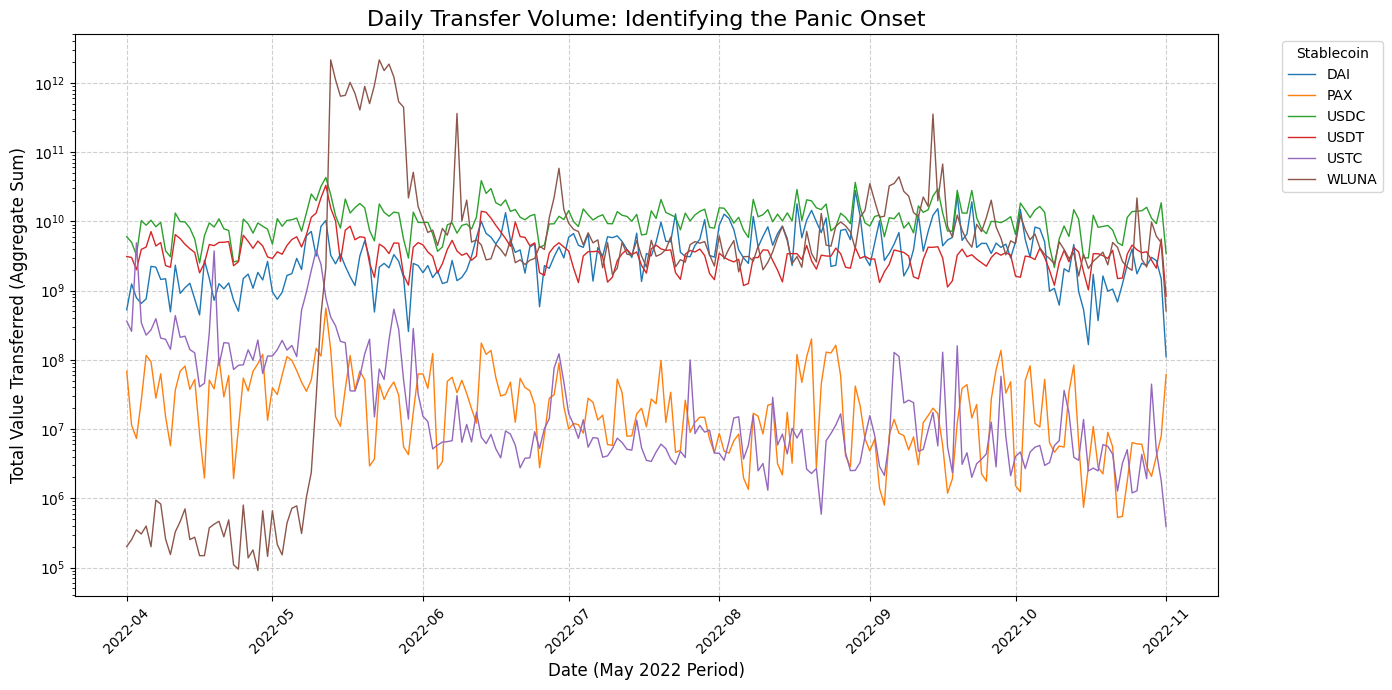

In [79]:
pivotD_df = daily_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivotD_df.columns:
    plt.plot(pivotD_df.index, pivotD_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Daily Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()

#### Zoomed in on may

(np.float64(19113.0), np.float64(19142.0))

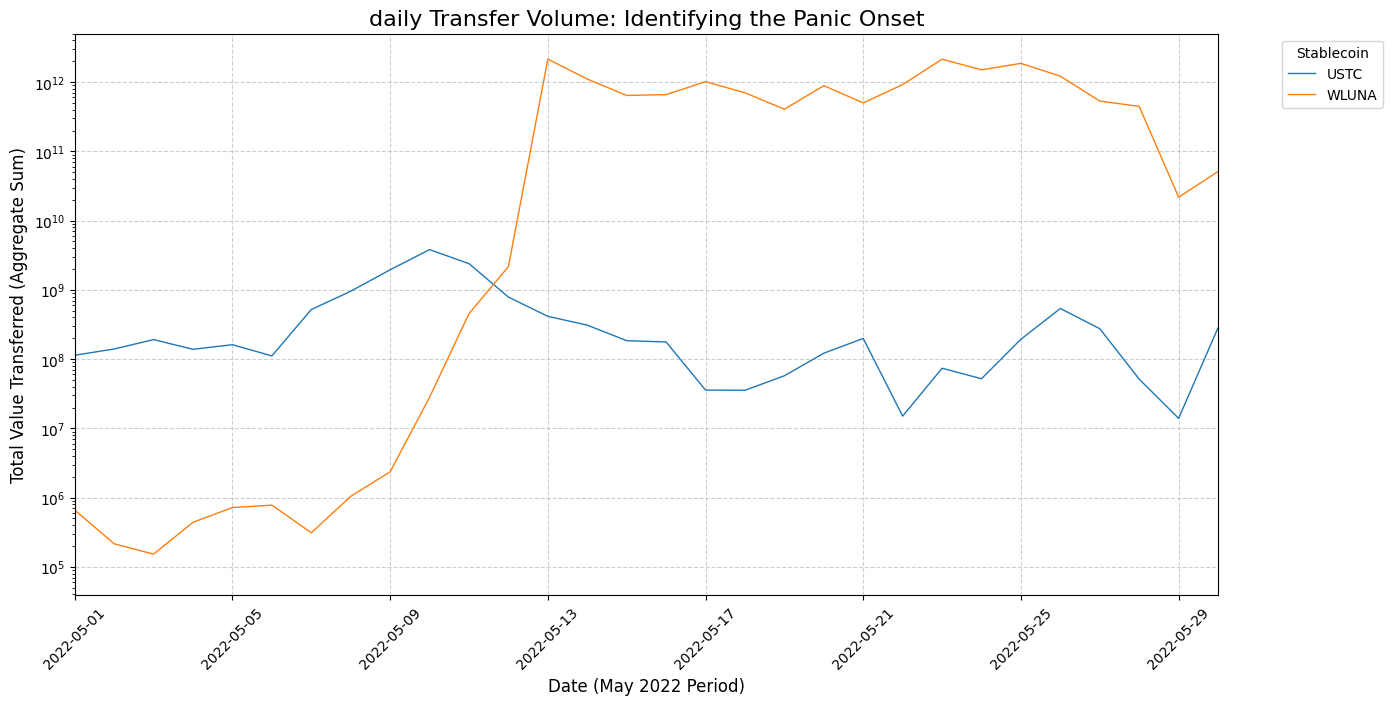

In [66]:
pivotD_df = daily_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivotD_df.columns:
    if coin_name == 'USTC' or coin_name == 'WLUNA':
        plt.plot(pivotD_df.index, pivotD_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('daily Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-01 00:00:00'), pd.Timestamp('2022-05-30 00:00:00'))

### hourly ver

In [67]:
# 4. Hourly Aggregation
# We group by the datetime (rounded to the hour) and the coin name
hourly_df = TTAC.groupby([pd.Grouper(key='datetime', freq='h'), 'coin_name'])['value'].sum().reset_index()

# Rename columns for clarity
hourly_df.rename(columns={'value': 'total_volume_transferred'}, inplace=True)
print(hourly_df)

                 datetime coin_name  total_volume_transferred
0     2022-04-01 11:00:00       DAI              2.174219e+07
1     2022-04-01 11:00:00       PAX              6.364146e+05
2     2022-04-01 11:00:00      USDC              2.282559e+08
3     2022-04-01 11:00:00      USDT              3.871481e+08
4     2022-04-01 11:00:00      USTC              1.058221e+07
...                   ...       ...                       ...
30623 2022-11-01 04:00:00       PAX              3.318194e+04
30624 2022-11-01 04:00:00      USDC              4.702541e+08
30625 2022-11-01 04:00:00      USDT              1.745930e+08
30626 2022-11-01 04:00:00      USTC              1.553252e+05
30627 2022-11-01 04:00:00     WLUNA              2.665641e+07

[30628 rows x 3 columns]


#### Plot graph over all datetimes

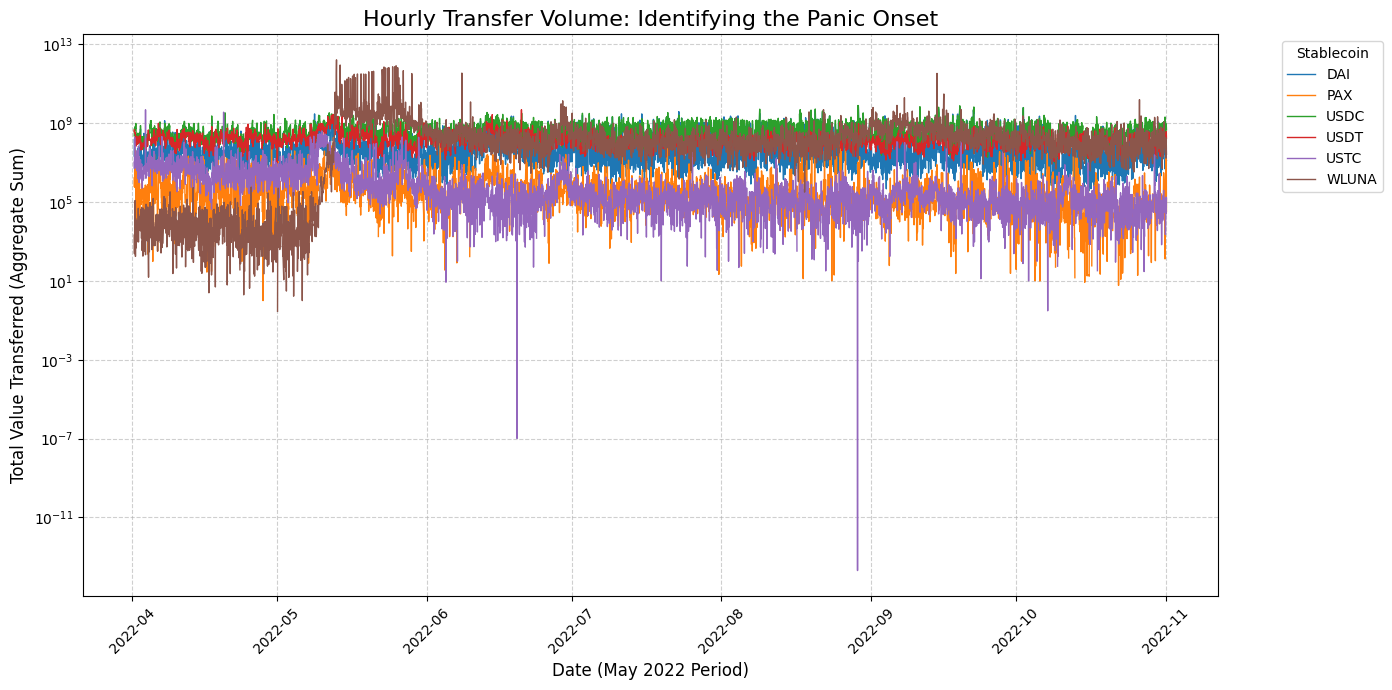

In [68]:
pivot_df = hourly_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Hourly Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()

#### Zoomed in on may

(np.float64(19120.0), np.float64(19132.0))

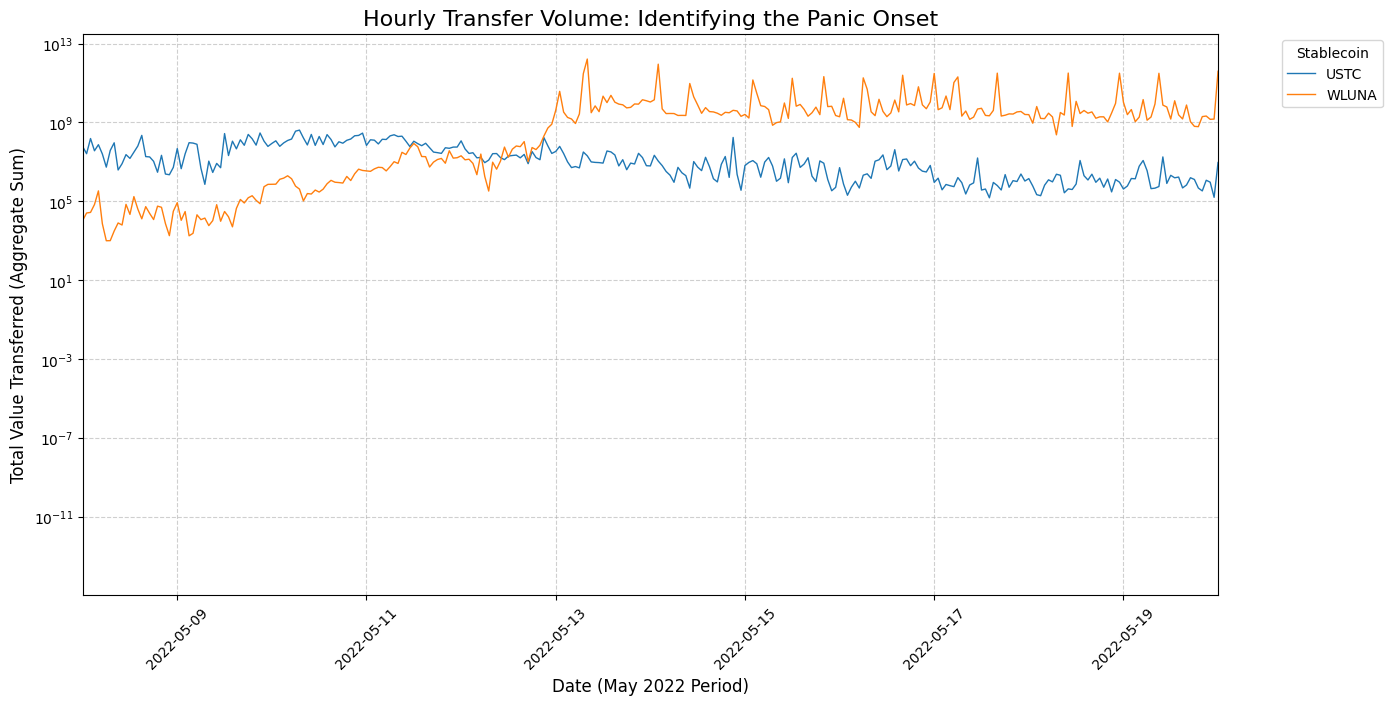

In [69]:
pivot_df = hourly_df.pivot(index='datetime', columns='coin_name', values='total_volume_transferred')
# 3. Create the Plot
plt.figure(figsize=(14, 7))
plt.yscale('log')

# Plot each coin
for coin_name in pivot_df.columns:
    if coin_name == 'USTC' or coin_name == 'WLUNA':
        plt.plot(pivot_df.index, pivot_df[coin_name], label=coin_name, linewidth=1)

# 4. Enhance the Chart for the Case Study
plt.title('Hourly Transfer Volume: Identifying the Panic Onset', fontsize=16)
plt.xlabel('Date (May 2022 Period)', fontsize=12)
plt.ylabel('Total Value Transferred (Aggregate Sum)', fontsize=12)
plt.legend(title='Stablecoin', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))

# Price

## file opening

In [37]:
with zipfile.ZipFile("ERC20-stablecoins.zip") as outer_zip:
    nested_zip = outer_zip.read("price_data.zip")
    # Open the nested zip
    with zipfile.ZipFile(io.BytesIO(nested_zip)) as inner_zip:
        # Open the CSV from the nested zip
        with inner_zip.open("price_data/dai_price_data.csv") as f:
            DAIP = pd.read_csv(f)
        with inner_zip.open("price_data/pax_price_data.csv") as f:
            PAXP = pd.read_csv(f)
        with inner_zip.open("price_data/usdc_price_data.csv") as f:
            USDCP = pd.read_csv(f)
        with inner_zip.open("price_data/usdt_price_data.csv") as f:
            USDTP = pd.read_csv(f)
        with inner_zip.open("price_data/ustc_price_data.csv") as f:
            USTCP = pd.read_csv(f)
        with inner_zip.open("price_data/wluna_price_data.csv") as f:
            WLUP = pd.read_csv(f)

## merge into a single dataframe

In [73]:
# List of your dataframes and their corresponding names
dfs = [DAIP, PAXP, USDCP, USDTP, USTCP, WLUP]
names = ['DAI', 'PAX', 'USDC', 'USDT', 'USTC', 'WLUNA']

# Add the coin name to each dataframe
for df, name in zip(dfs, names):
    df['coin_name'] = name

# Stack them into one master dataframe
all_prices = pd.concat(dfs, ignore_index=True)
print(all_prices)

       timestamp      open      high       low     close coin_name
0     1648857600  0.999900  1.000000  0.998900  1.000000       DAI
1     1648944000  1.000000  1.000000  0.998900  0.999000       DAI
2     1649030400  0.999000  1.000000  0.998900  0.999500       DAI
3     1649116800  0.999400  1.000000  0.998700  0.999900       DAI
4     1649203200  0.999900  1.000000  0.998800  0.999100       DAI
...          ...       ...       ...       ...       ...       ...
1285  1667001600  0.000239  0.000252  0.000235  0.000241     WLUNA
1286  1667088000  0.000241  0.000249  0.000229  0.000236     WLUNA
1287  1667174400  0.000236  0.000268  0.000230  0.000244     WLUNA
1288  1667260800  0.000244  0.000255  0.000233  0.000236     WLUNA
1289  1667347200  0.000236  0.000242  0.000210  0.000218     WLUNA

[1290 rows x 6 columns]


## data cleaning function

In [74]:
def clean_price_data(dfO):
    df = dfO.copy()
    # 1. Check for Nulls
    print("--- 1. Checking for Null Values ---")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0] if null_counts.any() else "No missing values found.")

    print("\n--- 2. Checking for Duplicate Transactions ---")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows found: {duplicates}")
    # Tip: In blockchain data, duplicates are rare but can happen if the scraper double-recorded a block.
    df = df.drop_duplicates(subset=['timestamp','coin_name'], keep='last')
    df = df.sort_values('timestamp')

    # 3. Handle Abnormal Values (OHLC Logic)
    print("\n--- 3. Checking for Abnormal Values ---")

    # A. Zero/Negative Price Check
    zero_prices = df[(df['close'] <= 0) | (df['open'] <= 0)].shape[0]

    # B. Spread Anomaly Check (High must be >= Low, and Open/Close must be between them)
    invalid_spread_mask = ~((df['high'] >= df['low']) &
                           (df['high'] >= df[['open', 'close']].max(axis=1)) &
                           (df['low'] <= df[['open', 'close']].min(axis=1)))
    invalid_spreads = invalid_spread_mask.sum()

    print(f"Zero or negative prices found: {zero_prices}")
    print(f"Invalid OHLC spreads found: {invalid_spreads}")

    # Apply the filters
    df = df[(df['close'] > 0) & (df['open'] > 0)]
    df = df[~invalid_spread_mask]
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

    return df

## data cleaning

In [75]:
APC = clean_price_data(all_prices)
print (APC)
APC.to_csv("AllPrices_cleaned.csv", index=False)

--- 1. Checking for Null Values ---
No missing values found.

--- 2. Checking for Duplicate Transactions ---
Duplicate rows found: 0

--- 3. Checking for Abnormal Values ---
Zero or negative prices found: 0
Invalid OHLC spreads found: 0
       timestamp        open        high        low       close coin_name  \
0     1648857600    0.999900    1.000000    0.99890    1.000000       DAI   
860   1648857600    1.000000    1.000000    0.99890    1.000000      USTC   
1075  1648857600  103.230000  107.280000  100.03000  105.870000     WLUNA   
645   1648857600    1.000000    1.000000    1.00000    1.000000      USDT   
430   1648857600    0.999500    1.000000    0.99900    0.999900      USDC   
...          ...         ...         ...        ...         ...       ...   
859   1667347200    0.999900    0.999900    0.99980    0.999900      USDT   
429   1667347200    0.999000    1.010000    0.99420    0.998300       PAX   
214   1667347200    0.999900    1.000000    0.99900    0.999900       

## Alternatively used cleaned csv file to load data

In [ ]:
APC = pd.read_csv("data/AllPrices_cleaned.csv")

## add column interday range(high-low)

In [47]:
APC["intraday range"]=APC["high"]-APC["low"]
print(APC)

       timestamp        open        high        low       close coin_name  \
0     1648857600    0.999900    1.000000    0.99890    1.000000       DAI   
860   1648857600    1.000000    1.000000    0.99890    1.000000      USTC   
1075  1648857600  103.230000  107.280000  100.03000  105.870000     WLUNA   
645   1648857600    1.000000    1.000000    1.00000    1.000000      USDT   
430   1648857600    0.999500    1.000000    0.99900    0.999900      USDC   
...          ...         ...         ...        ...         ...       ...   
859   1667347200    0.999900    0.999900    0.99980    0.999900      USDT   
429   1667347200    0.999000    1.010000    0.99420    0.998300       PAX   
214   1667347200    0.999900    1.000000    0.99900    0.999900       DAI   
1074  1667347200    0.037760    0.038480    0.03715    0.037260      USTC   
1289  1667347200    0.000236    0.000242    0.00021    0.000218     WLUNA   

       datetime  intraday range  
0    2022-04-02        0.001100  
860  20

## create piviot table by coins

In [48]:
# 1. Create a pivot table for Closing Prices
# This is used to visualize the "Death Spiral" of USTC and WLUNA
volatilit_pivot = APC.pivot(index='datetime', columns='coin_name', values='close')

# 2. Create a pivot table for Intraday Range
# This identifies periods of high stress and automated arbitrage failure
volatility_pivot = APC.pivot(index='datetime', columns='coin_name', values='intraday range')


print("Price Pivot Table Preview:")
print(volatilit_pivot.head())

print("intraday range Pivot Table Preview:")
print(volatility_pivot.head())

Price Pivot Table Preview:
coin_name      DAI     PAX    USDC  USDT    USTC   WLUNA
datetime                                                
2022-04-02  1.0000  1.0000  0.9999   1.0  1.0000  105.87
2022-04-03  0.9990  1.0000  0.9993   1.0  1.0000  115.49
2022-04-04  0.9995  1.0000  1.0000   1.0  0.9999  113.46
2022-04-05  0.9999  1.0000  1.0000   1.0  1.0000  115.96
2022-04-06  0.9991  0.9998  0.9997   1.0  0.9984  116.10
intraday range Pivot Table Preview:
coin_name      DAI     PAX    USDC  USDT    USTC  WLUNA
datetime                                               
2022-04-02  0.0011  0.0038  0.0010   0.0  0.0011   7.25
2022-04-03  0.0011  0.0018  0.0009   0.0  0.0014  11.02
2022-04-04  0.0011  0.0025  0.0015   0.0  0.0010   4.97
2022-04-05  0.0013  0.0014  0.0011   0.0  0.0037   6.05
2022-04-06  0.0012  0.0027  0.0010   0.0  0.0024   2.67


## Analysis of closing price over time

### plot graph of closing price against time

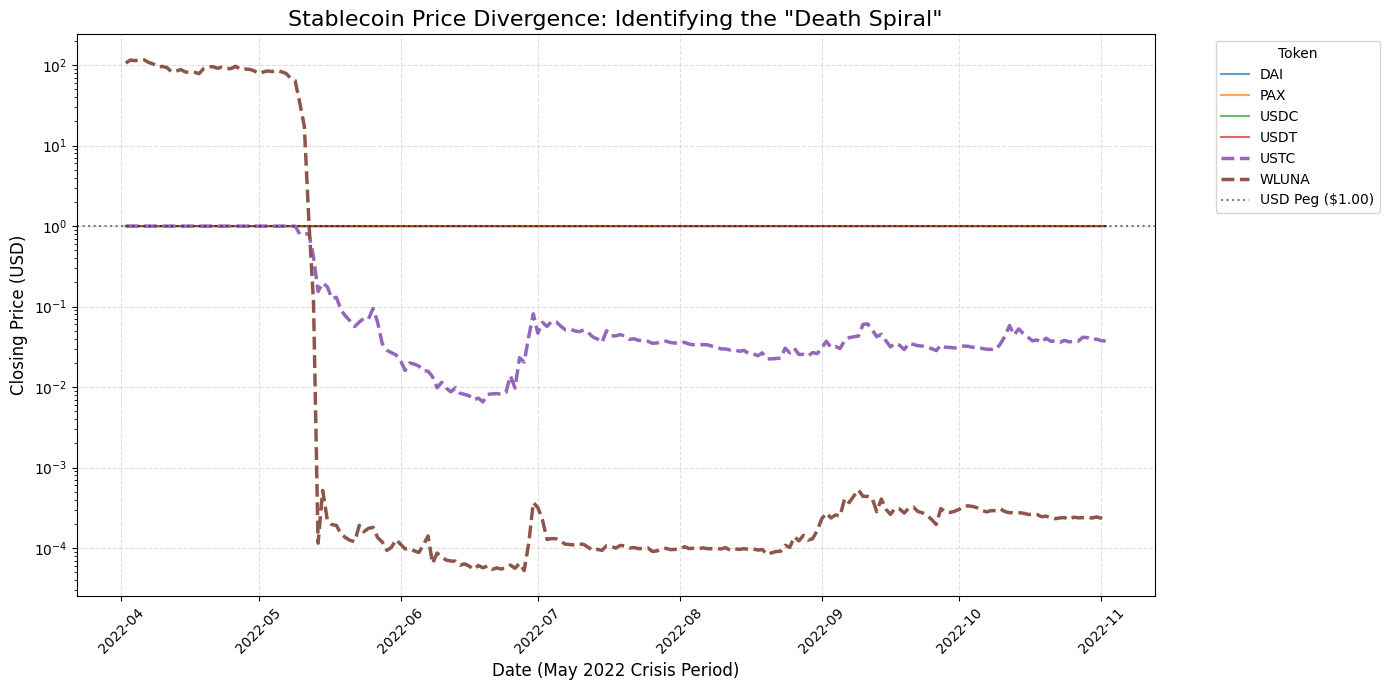

In [49]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatilit_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')

# 4. Enhance the chart
plt.title('Stablecoin Price Divergence: Identifying the "Death Spiral"', fontsize=16)
plt.xlabel('Date (May 2022 Crisis Period)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.show()

### Zoomed in to may

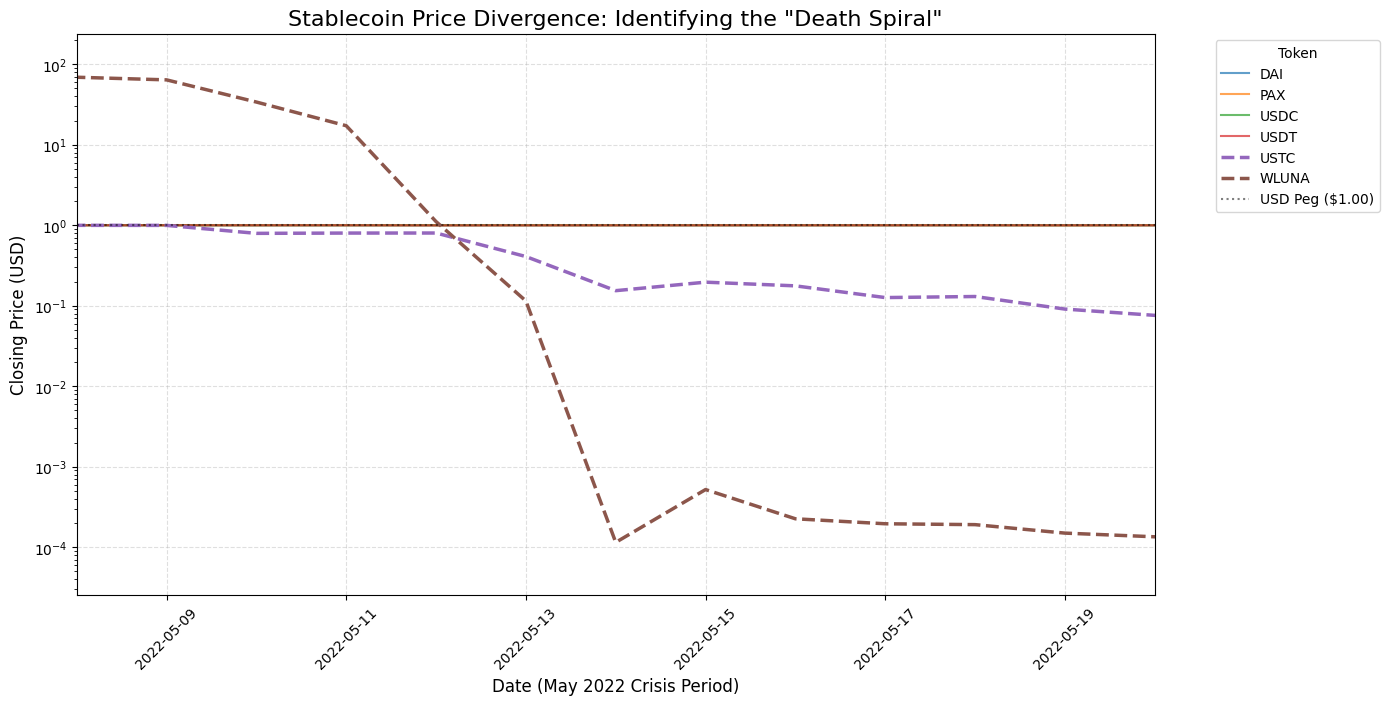

In [50]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatilit_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatilit_pivot.index, volatilit_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')

# 4. Enhance the chart
plt.title('Stablecoin Price Divergence: Identifying the "Death Spiral"', fontsize=16)
plt.xlabel('Date (May 2022 Crisis Period)', fontsize=12)
plt.ylabel('Closing Price (USD)', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))
plt.show()

## Analysis of interday range over time

### plot of interday range against time

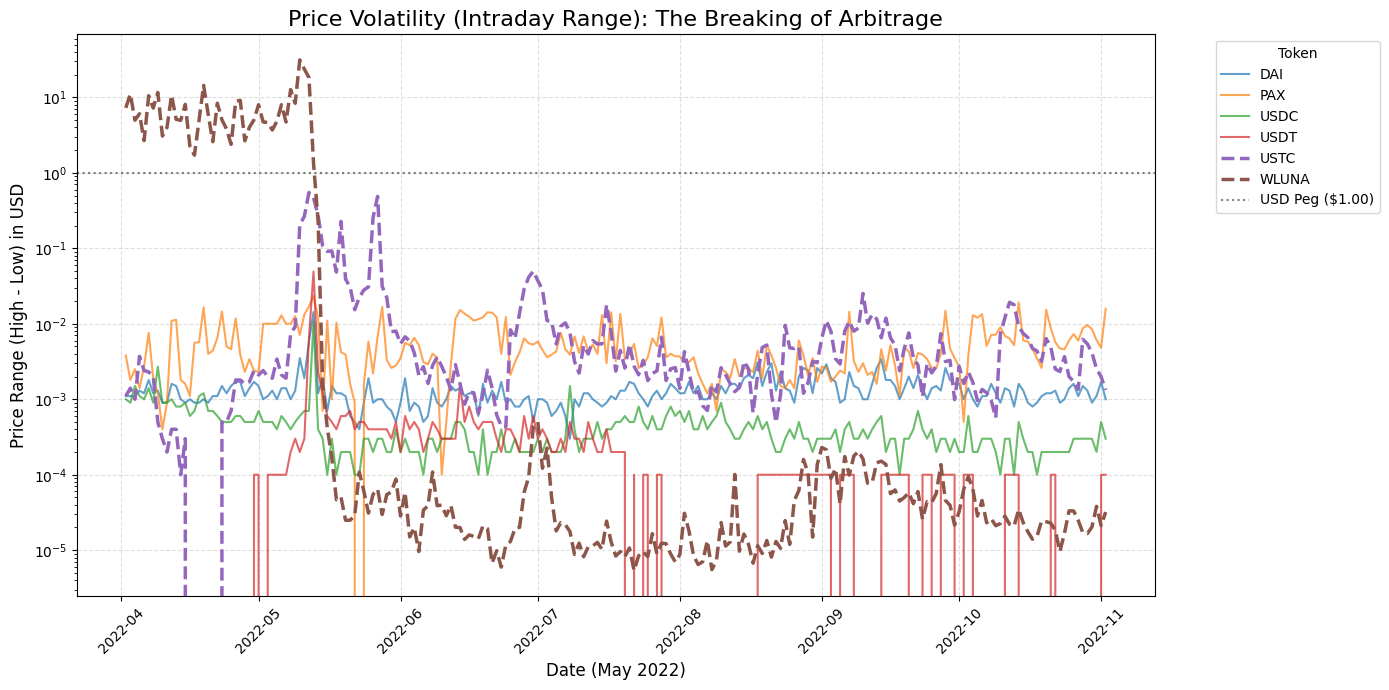

In [58]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatility_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')

# 4. Enhance the chart
plt.title('Price Volatility (Intraday Range): The Breaking of Arbitrage', fontsize=16)
plt.xlabel('Date (May 2022)', fontsize=12)
plt.ylabel('Price Range (High - Low) in USD', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.show()

### zoom into may


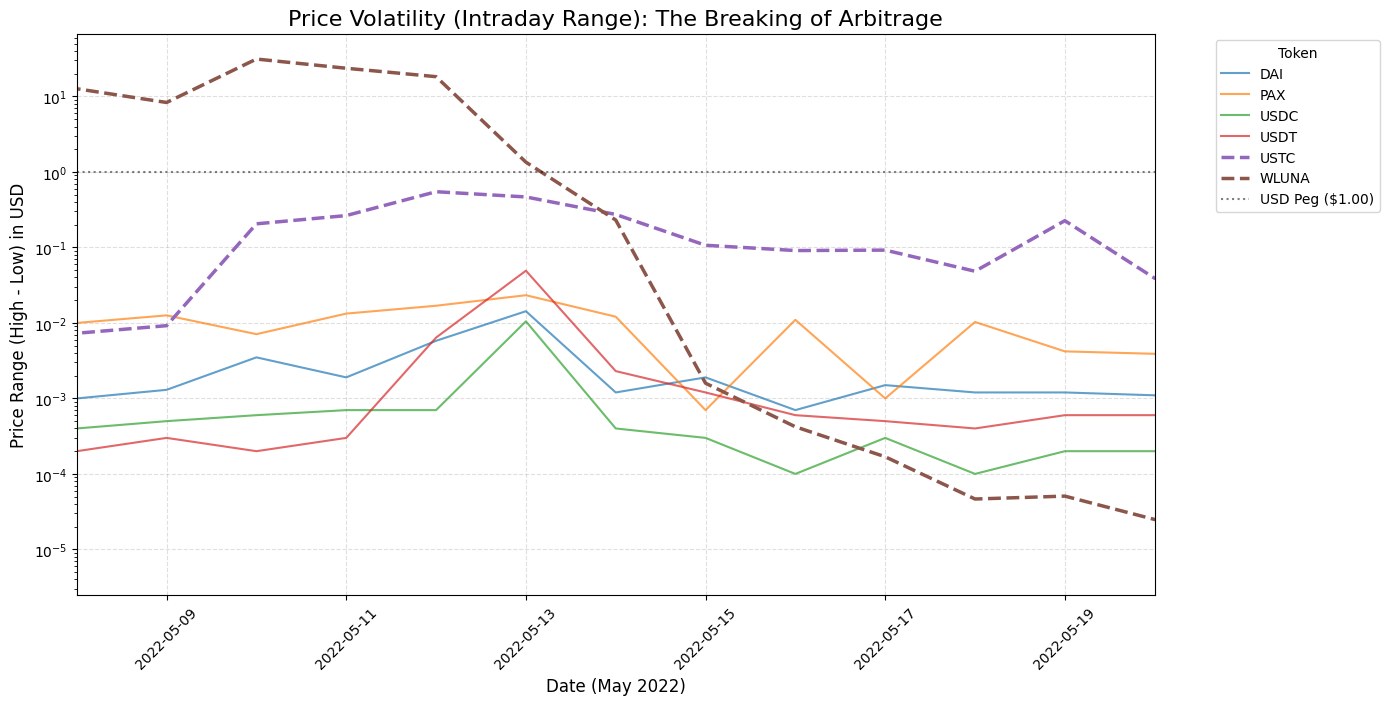

In [57]:
# 1. Initialize the figure
plt.figure(figsize=(14, 7))

# 2. Plot each coin from your pivot table
for coin in volatility_pivot.columns:
    if coin in ['USTC', 'WLUNA']:
        # Highlight the crashing coins with a thicker dashed line
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, linewidth=2.5, linestyle='--')
    else:
        # Others are shown normally to check for peg stability
        plt.plot(volatility_pivot.index, volatility_pivot[coin], label=coin, alpha=0.7)

# 3. Add a reference line for the $1.00 USD Peg
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5, label='USD Peg ($1.00)')

# 4. Enhance the chart
plt.title('Price Volatility (Intraday Range): The Breaking of Arbitrage', fontsize=16)
plt.xlabel('Date (May 2022)', fontsize=12)
plt.ylabel('Price Range (High - Low) in USD', fontsize=12)
plt.legend(title='Token', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(rotation=45)

# IMPORTANT: Using a Log Scale helps visualize WLUNA's drop from $80 to $0.0001
plt.yscale('log')

plt.tight_layout()
plt.xlim(pd.Timestamp('2022-05-08 00:00:00'), pd.Timestamp('2022-05-20 00:00:00'))
plt.show()

# Citation

@inproceedings{chartalistNeurips2022,
  author    = {Kiarash Shamsi and Yulia R. Gel and  Murat Kantarcioglu and Cuneyt G. Akcora},
  title     = {Chartalist: Labeled Graph Datasets for UTXO and Account-based Blockchains},
  booktitle = {Advances in Neural Information Processing Systems 36: Annual Conference on Neural Information Processing Systems 2022, NeurIPS 2022, November 29-December 1, 2022, New Orleans, LA, USA},
  pages     = {1--14},
  year      = {2022},
  url       = {https://openreview.net/pdf?id=10iA3OowAV3}
  }